In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Weights & Biases integration
!pip install wandb -q
import wandb

In [2]:
# Load the Iris dataset
from sklearn.datasets import load_iris

# Load data
iris = load_iris()
X = iris.data
y = iris.target

# Convert to dataframe for easier handling
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
df['species'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print("\nDataset preview:")
print(df.head())
print("\nClass distribution:")
print(df['species'].value_counts())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to one-hot encoding for multi-class classification
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)

Dataset shape: (150, 6)

Dataset preview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  

Class distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


In [3]:
# Add missing datetime import
import datetime

# Initialize Weights & Biases
wandb.init(project="iris-classification", name="iris-dnn-model")

# Define the model architecture - a simple neural network for classification
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # 3 classes in Iris dataset
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pns00911 (pns00911-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,499 (9.76 KB)

 Trainable params: 2,499 (9.76 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Use TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot)
print(f"Test accuracy: {test_accuracy:.4f}")

# Log final results to wandb
wandb.log({
    "test_accuracy": test_accuracy,
    "test_loss": test_loss
})

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.4320 - loss: 1.0485 - val_accuracy: 0.5833 - val_loss: 0.9745
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6732 - loss: 0.8951 - val_accuracy: 0.5833 - val_loss: 0.8881
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6882 - loss: 0.8419 - val_accuracy: 0.6667 - val_loss: 0.8114
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7686 - loss: 0.7608 - val_accuracy: 0.7083 - val_loss: 0.7446
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7757 - loss: 0.7016 - val_accuracy: 0.7500 - val_loss: 0.6902
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.7948 - loss: 0.6338 - val_accuracy: 0.7500 - val_loss: 0.6469
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8470 - loss: 0.5864 - val_accuracy: 0.7500 - val_loss: 0.6131
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8124 - loss: 0.5419 - val_accuracy: 0.7500 - val_

In [5]:
# Get model predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert one-hot encoded test labels back to class indices for metrics calculation
y_test_class = np.argmax(y_test_onehot, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_class, y_pred)
precision = precision_score(y_test_class, y_pred, average='weighted')
recall = recall_score(y_test_class, y_pred, average='weighted')
f1 = f1_score(y_test_class, y_pred, average='weighted')

# Print metrics
print("Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
class_names = iris.target_names
print(classification_report(y_test_class, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Classification Metrics:
Accuracy: 0.9333
Precision: 0.9333
Recall: 0.9333
F1 Score: 0.9333

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



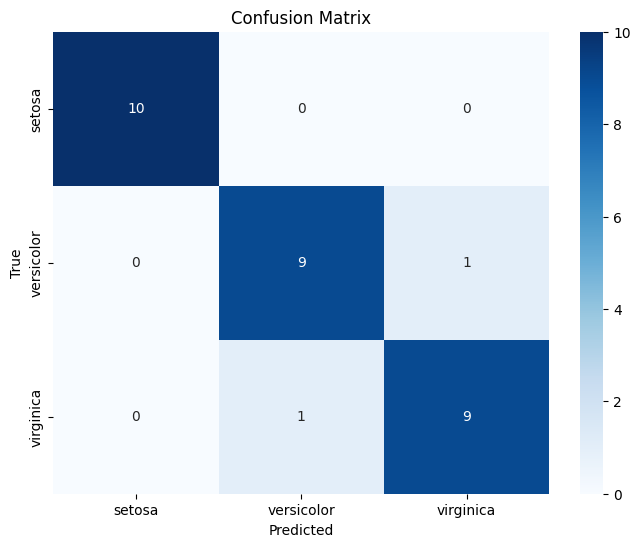

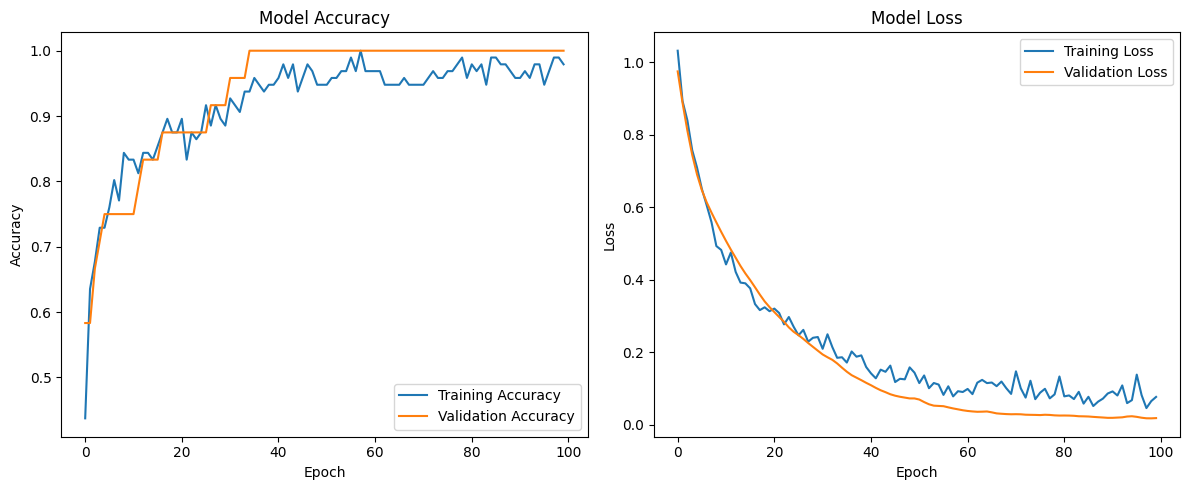

In [6]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_class, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_classification.png')
plt.show()

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history_classification.png')
plt.show()

# Log artifacts to wandb
wandb.log({
    "confusion_matrix": wandb.Image('confusion_matrix_classification.png'),
    "training_history": wandb.Image('training_history_classification.png')
})

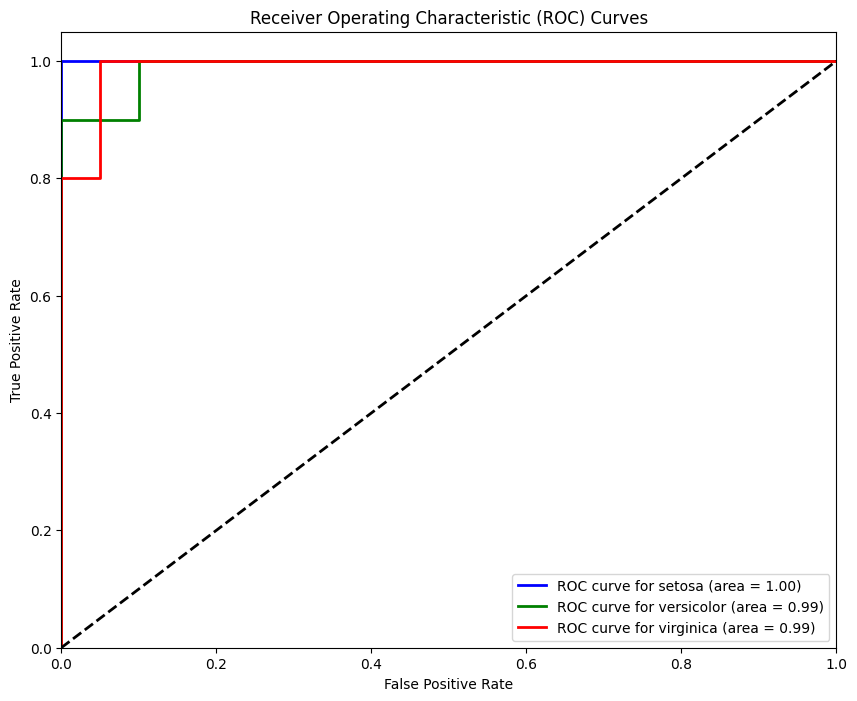

In [7]:
# Create ROC curves for each class
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red']
for i, color, class_name in zip(range(3), colors, class_names):
    # One-vs-Rest approach for multiclass ROC
    y_test_binary = (y_test_class == i).astype(int)
    y_score = y_pred_proba[:, i]

    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve for {class_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig('roc_curves_classification.png')
plt.show()

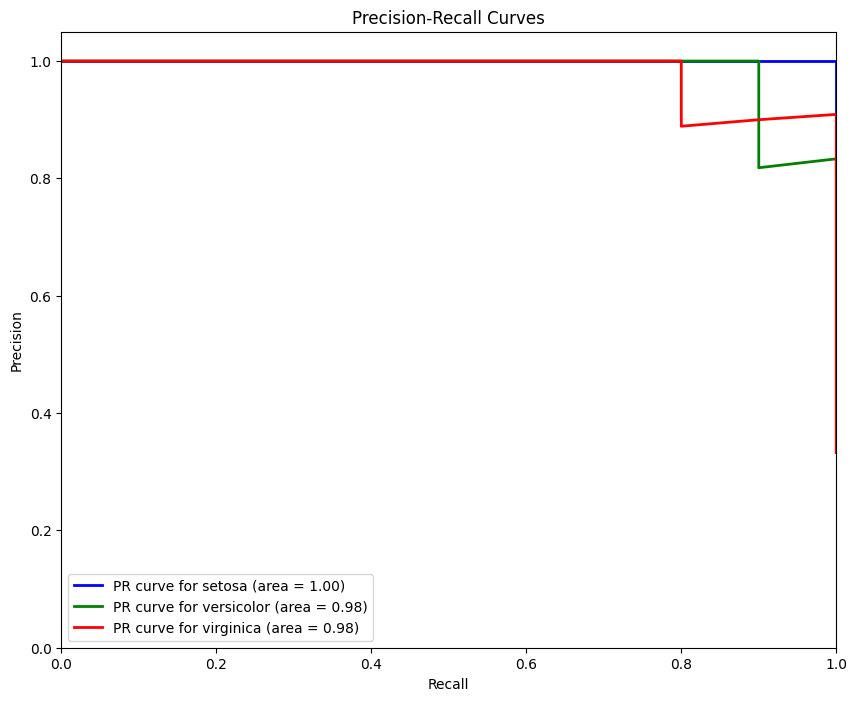

In [8]:
# Create Precision-Recall curves for each class
plt.figure(figsize=(10, 8))

for i, color, class_name in zip(range(3), colors, class_names):
    # One-vs-Rest approach for multiclass PR curve
    y_test_binary = (y_test_class == i).astype(int)
    y_score = y_pred_proba[:, i]

    precision, recall, _ = precision_recall_curve(y_test_binary, y_score)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, color=color, lw=2,
             label=f'PR curve for {class_name} (area = {pr_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.savefig('pr_curves_classification.png')
plt.show()

# Log these to wandb
wandb.log({
    "roc_curves": wandb.Image('roc_curves_classification.png'),
    "pr_curves": wandb.Image('pr_curves_classification.png')
})

In [9]:
# Get indices of correctly and incorrectly classified samples
correct_indices = np.where(y_pred == y_test_class)[0]
incorrect_indices = np.where(y_pred != y_test_class)[0]

print(f"Number of correctly classified samples: {len(correct_indices)}")
print(f"Number of incorrectly classified samples: {len(incorrect_indices)}")

# Error analysis: examine misclassified examples
if len(incorrect_indices) > 0:
    print("\nMisclassified Samples Analysis:")
    for idx in incorrect_indices:
        true_class = class_names[y_test_class[idx]]
        pred_class = class_names[y_pred[idx]]
        print(f"Sample {idx}: True class = {true_class}, Predicted class = {pred_class}")
        print(f"Feature values: {X_test[idx]}")
        print(f"Prediction probabilities: {y_pred_proba[idx]}")
        print("---")
else:
    print("\nNo misclassified samples in the test set!")

Number of correctly classified samples: 28
Number of incorrectly classified samples: 2

Misclassified Samples Analysis:
Sample 23: True class = virginica, Predicted class = versicolor
Feature values: [6.1 2.6 5.6 1.4]
Prediction probabilities: [2.0508099e-04 5.6213045e-01 4.3766460e-01]
---
Sample 25: True class = versicolor, Predicted class = virginica
Feature values: [6.7 3.  5.  1.7]
Prediction probabilities: [4.2698724e-04 1.5626448e-01 8.4330851e-01]
---


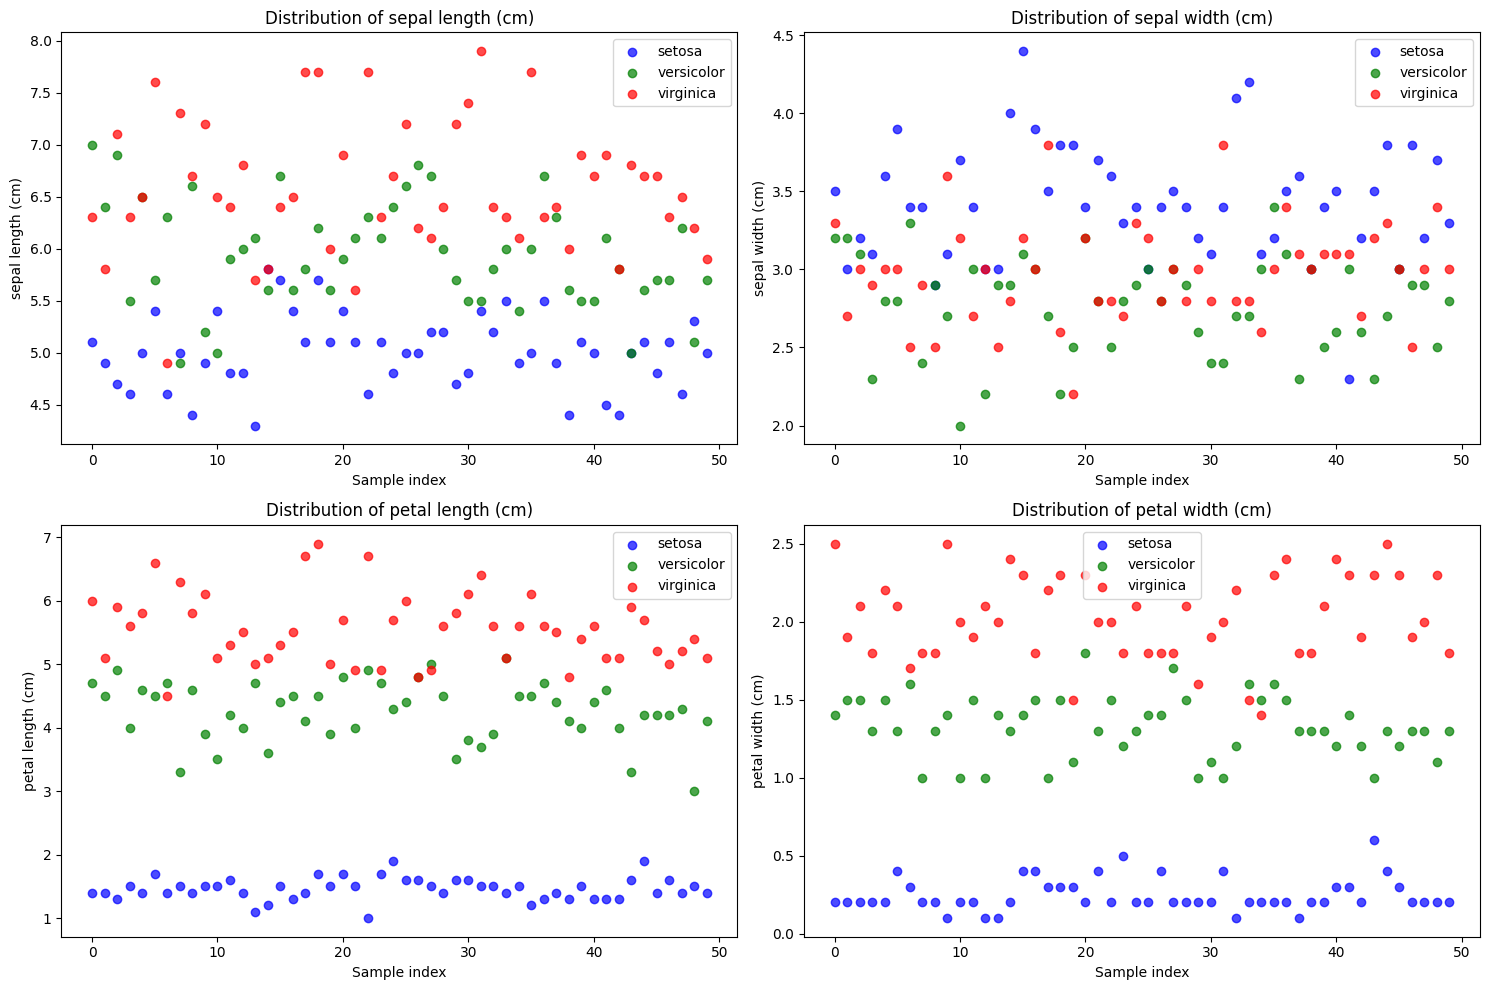

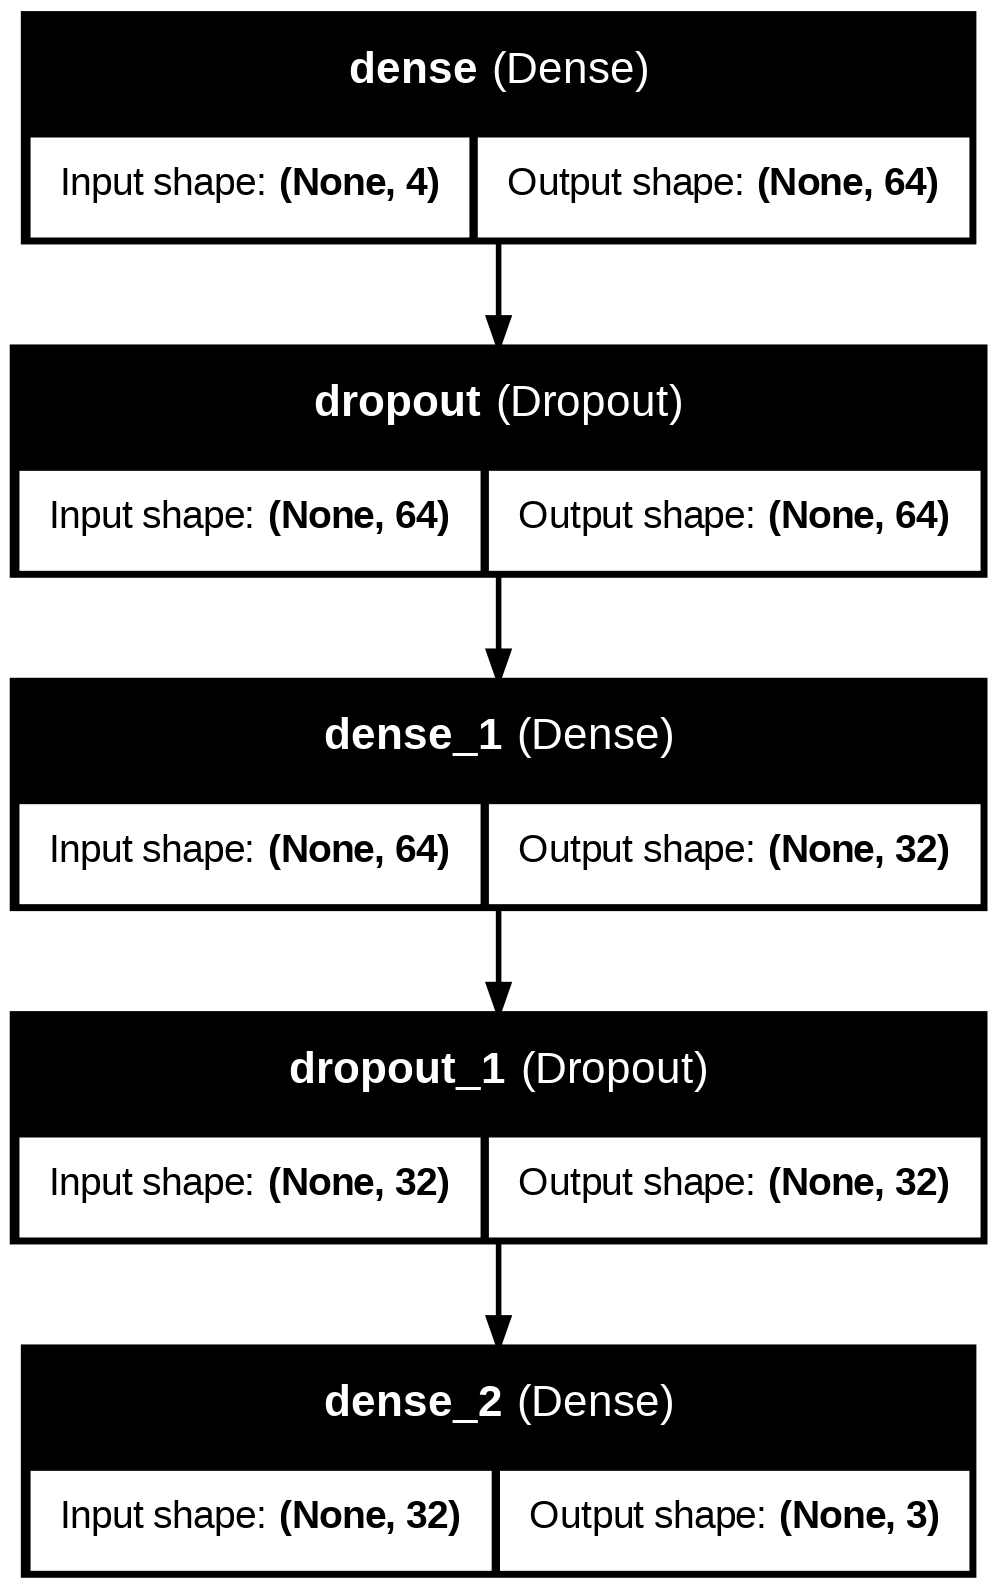

In [10]:
# Visualize the feature distributions for each class
plt.figure(figsize=(15, 10))
for i, feature in enumerate(iris.feature_names):
    plt.subplot(2, 2, i+1)
    for target, color in zip(range(3), ['blue', 'green', 'red']):
        plt.scatter(range(len(df[df['target'] == target])),
                   df[df['target'] == target][feature],
                   color=color,
                   label=class_names[target],
                   alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Sample index')
    plt.ylabel(feature)
    plt.legend()
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

# Create a model diagram visualization
from tensorflow.keras.utils import plot_model

# Create a model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

# Display the model diagram
from IPython.display import Image
Image('model_diagram.png')

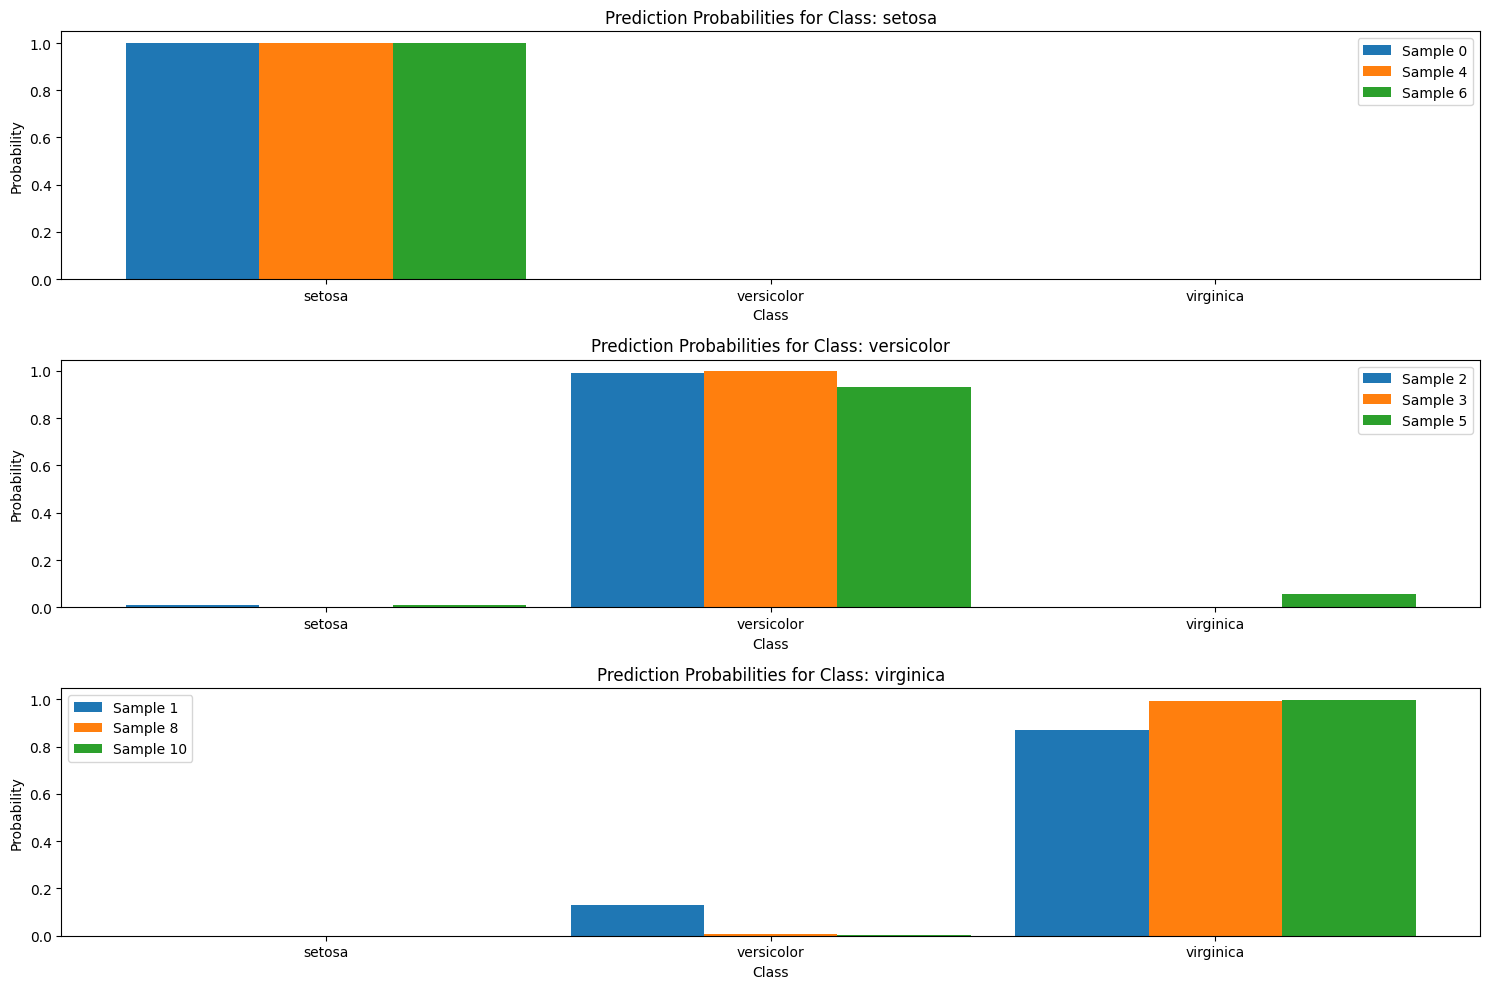

In [ ]:
# Create a visualization for a few samples from each class
plt.figure(figsize=(15, 10))

# Get samples for each class
class_samples = {}
for i, class_name in enumerate(class_names):
    class_indices = np.where(y_test_class == i)[0]
    class_samples[class_name] = class_indices[:3]  # Get 3 samples from each class

# Visualize predictions and actual values for selected samples
bar_width = 0.3
index = np.arange(len(class_names))

for class_idx, class_name in enumerate(class_names):
    plt.subplot(3, 1, class_idx+1)

    for i, sample_idx in enumerate(class_samples[class_name]):
        predictions = y_pred_proba[sample_idx]
        plt.bar(index + i*bar_width, predictions, bar_width,
                label=f'Sample {sample_idx}')

    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title(f'Prediction Probabilities for Class: {class_name}')
    plt.xticks(index + bar_width, class_names)
    plt.legend()

plt.tight_layout()
plt.savefig('class_predictions.png')
plt.show()

# Log to wandb
wandb.log({
    "class_predictions": wandb.Image('class_predictions.png'),
    "feature_distributions": wandb.Image('feature_distributions.png'),
    "model_diagram": wandb.Image('model_diagram.png')
})